In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [2]:
import re
import os
import math
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score, confusion_matrix

from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import pearsonr

from cycler import cycler
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Metrics Function

In [ ]:
def compute_patient_metrics(
    df: pd.DataFrame,
    *,
    id_col: str = "patient_id",
    true_col: str = "true_severity",
    pred_col: str = "pred_severity",
    drop_na: bool = True,
    auto_detect: bool = True,
) -> pd.DataFrame:
    """
    df에서 patient_id 별로 Accuracy / Weighted Precision / Weighted Recall / Weighted F1 계산.
    OVERALL 행은 포함하지 않습니다.

    - 기본은 severity 컬럼을 사용(true_severity/pred_severity).
    - auto_detect=True 인 경우, 지정된 컬럼이 없으면 task 컬럼(true_task/pred_task)로 자동 대체.
    - 라벨이 숫자형 or 숫자 문자열이면 int로, 그 외는 문자열로 통일.
    """

    data = df.copy()

    # 1) 컬럼 자동 감지(필요 시)
    if auto_detect:
        need = {id_col, true_col, pred_col} - set(data.columns)
        if need:
            # severity 기본값이 없으면 task 쌍을 시도
            if {"true_task", "pred_task"}.issubset(data.columns):
                true_col, pred_col = "true_task", "pred_task"
            else:
                # 그래도 없으면 에러
                missing = {id_col, true_col, pred_col} - set(data.columns)
                if missing:
                    raise KeyError(f"다음 컬럼이 필요합니다: {sorted(missing)}")
    else:
        # auto_detect 사용하지 않을 때는 명시 컬럼 검사
        missing = {id_col, true_col, pred_col} - set(data.columns)
        if missing:
            raise KeyError(f"다음 컬럼이 필요합니다: {sorted(missing)}")

    # 2) 결측치 처리
    if drop_na:
        data = data.dropna(subset=[id_col, true_col, pred_col])

    # 3) 라벨 타입 통일: 숫자/숫자문자열 → int, 그 외 → str
    def _coerce_labels(s: pd.Series) -> pd.Series:
        if is_numeric_dtype(s):
            return s.astype(int)
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().all():      # 전부 숫자 문자열인 경우
            return s_num.astype(int)
        return s.astype(str)         # 혼합/문자 라벨은 문자열로

    data[true_col] = _coerce_labels(data[true_col])
    data[pred_col] = _coerce_labels(data[pred_col])

    # 4) 환자별 메트릭 계산
    rows = []
    for pid, g in data.groupby(id_col, sort=True):
        y_true = g[true_col].values
        y_pred = g[pred_col].values
        n = len(g)

        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0
        )
        rows.append([pid, n, acc, prec, rec, f1])

    result = pd.DataFrame(
        rows, columns=[id_col, "n", "accuracy", "precision_w", "recall_w", "f1_w"]
    )
    return result

# Table

## Supplementary Table 2

In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/MS/ETAnalysis/Data/relabel_md_k5.csv')
raw_df

df = raw_df.copy()
df["target_k5_14"] = df["target_k5"] + 1   # 0→1, 1→2, 2→3, 3→4

sev_order = [1, 2, 3, 4]

# 1) patient_id, session 별 target_k5_14 카운트
ct = (
    pd.crosstab(
        [df["patient_id"], df["session"]],
        df["target_k5_14"]
    )
    .reindex(columns=sev_order, fill_value=0)
)

# 2) 열 이름을 Sev 1 ~ Sev 4로 변경
ct.columns = [f"Sev {c}" for c in ct.columns]

# 3) Total 열 추가
ct["Total"] = ct.sum(axis=1)

# 4) Mean Sev 계산 (가중 평균: 1,2,3,4 점수) + 소수 둘째 자리까지
weights = pd.Series({"Sev 1": 1, "Sev 2": 2, "Sev 3": 3, "Sev 4": 4})
mean_sev = (
    ct[["Sev 1", "Sev 2", "Sev 3", "Sev 4"]]
    .mul(weights, axis=1)
    .sum(axis=1) / ct["Total"]
).round(2)

# 5) Mean Sev를 Sev 4와 Total 사이에 삽입
insert_loc = ct.columns.get_loc("Total")
ct.insert(insert_loc, "Mean Sev", mean_sev)

# 6) TETRAS: patient_id, session 별 tetras_score (각 조합에 하나의 값만 있다고 가정)
tetras = (
    df.groupby(["patient_id", "session"])["tetras_score"]
      .first()                 # 또는 mean(), max() 등. 값이 하나라면 first로 충분
      .reindex(ct.index)       # crosstab 인덱스와 정렬 일치
)

# 7) TETRAS를 Mean Sev와 Total 사이(= Total 바로 앞)에 삽입
insert_loc = ct.columns.get_loc("Total")   # Mean Sev가 들어간 뒤의 Total 위치
ct.insert(insert_loc, "TETRAS", tetras)

# 8) 인덱스 풀어서 최종 테이블
table = (
    ct
    .reset_index()
    .rename(columns={"patient_id": "Patient", "session": "Session"})
)

table

,Patient,Session,Sev 1,Sev 2,Sev 3,Sev 4,Mean Sev,TETRAS,Total
0,1,1,12,8,2,0,1.55,3,22
1,1,2,5,0,0,0,1.00,2,5
2,1,3,8,2,4,0,1.71,2,14
3,2,1,3,3,1,0,1.71,3,7
4,2,2,3,5,8,2,2.50,2,18
5,3,1,0,1,1,9,3.73,4,11
6,3,2,0,0,0,14,4.00,1,14
7,3,3,1,3,3,1,2.50,2,8
8,3,4,2,1,6,6,3.07,2,15
9,3,5,0,3,5,5,3.15,1,13


In [ ]:
table.to_csv('/content/drive/MyDrive/MS/ETAnalysis/figure/Table4.csv', index=False)

# Inference

## Multimodal

### ACC encoder : LSTM

In [ ]:
modal = 'multi'
acc_name = 'LSTM'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, traj_name, '='*30)
    # traj_name = 'LSTM'
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.7920 | std = 0.0960
precision_w  | mean = 0.7969 | std = 0.0908
f1_w         | mean = 0.7735 | std = 0.1049

============================== ResNet18 ==============================
accuracy     | mean = 0.5849 | std = 0.1752
precision_w  | mean = 0.5153 | std = 0.2105
f1_w         | mean = 0.5397 | std = 0.1905

============================== TimesNet ==============================
accuracy     | mean = 0.8058 | std = 0.1266
precision_w  | mean = 0.8234 | std = 0.1132
f1_w         | mean = 0.8015 | std = 0.1274

============================== MyWaveNet ==============================
accuracy     | mean = 0.8387 | std = 0.1269
precision_w  | mean = 0.8387 | std = 0.1373
f1_w         | mean = 0.8257 | std = 0.1436



### ACC encoder : ResNet18

In [ ]:
modal = 'multi'
acc_name = 'ResNet18'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, traj_name, '='*30)
    # traj_name = 'LSTM'
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.8193 | std = 0.0599
precision_w  | mean = 0.8146 | std = 0.0702
f1_w         | mean = 0.8078 | std = 0.0658

============================== ResNet18 ==============================
accuracy     | mean = 0.8626 | std = 0.0901
precision_w  | mean = 0.8511 | std = 0.0969
f1_w         | mean = 0.8515 | std = 0.0945

============================== TimesNet ==============================
accuracy     | mean = 0.7759 | std = 0.2141
precision_w  | mean = 0.7841 | std = 0.1914
f1_w         | mean = 0.7585 | std = 0.2212

============================== MyWaveNet ==============================
accuracy     | mean = 0.8362 | std = 0.1087
precision_w  | mean = 0.8178 | std = 0.1265
f1_w         | mean = 0.8189 | std = 0.1198



### ACC encoder : TimesNet

In [ ]:
modal = 'multi'
acc_name = 'TimesNet'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, traj_name, '='*30)
    # traj_name = 'LSTM'
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.6497 | std = 0.1904
precision_w  | mean = 0.6344 | std = 0.2453
f1_w         | mean = 0.6218 | std = 0.2250

============================== ResNet18 ==============================
accuracy     | mean = 0.5680 | std = 0.2152
precision_w  | mean = 0.5757 | std = 0.2445
f1_w         | mean = 0.5334 | std = 0.2356

============================== TimesNet ==============================
accuracy     | mean = 0.6081 | std = 0.2194
precision_w  | mean = 0.5933 | std = 0.2921
f1_w         | mean = 0.5758 | std = 0.2637

============================== MyWaveNet ==============================
accuracy     | mean = 0.6640 | std = 0.1896
precision_w  | mean = 0.7110 | std = 0.1859
f1_w         | mean = 0.6396 | std = 0.2089



In [ ]:
metrics_df

,patient_id,n,accuracy,precision_w,recall_w,f1_w
0,1,41,0.853659,0.857724,0.853659,0.839800
1,2,25,0.640000,0.599048,0.640000,0.572513
2,3,61,0.491803,0.565674,0.491803,0.468863
3,4,62,0.661290,0.667473,0.661290,0.660574
4,5,22,0.818182,0.817016,0.818182,0.785606
5,6,9,1.000000,1.000000,1.000000,1.000000
6,7,12,0.500000,0.772727,0.500000,0.406250
7,8,30,0.566667,0.753725,0.566667,0.646154
8,9,36,0.444444,0.365961,0.444444,0.376478


### ACC encoder : MyWaveNet

In [ ]:
modal = 'multi'
acc_name = 'MyWaveNet'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, traj_name, '='*30)
    # traj_name = 'LSTM'
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.9032 | std = 0.0829
precision_w  | mean = 0.9167 | std = 0.0727
f1_w         | mean = 0.9050 | std = 0.0813

============================== ResNet18 ==============================
accuracy     | mean = 0.8601 | std = 0.1348
precision_w  | mean = 0.8799 | std = 0.1069
f1_w         | mean = 0.8542 | std = 0.1442

============================== TimesNet ==============================
accuracy     | mean = 0.9007 | std = 0.0678
precision_w  | mean = 0.9052 | std = 0.0608
f1_w         | mean = 0.8971 | std = 0.0677

============================== MyWaveNet ==============================
accuracy     | mean = 0.9043 | std = 0.0778
precision_w  | mean = 0.9076 | std = 0.0800
f1_w         | mean = 0.8993 | std = 0.0853



### GAP

In [ ]:
modal = 'multi'
acc_name = 'MyWaveNet'
time_pool = 'gap'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, traj_name, '='*30)
    # traj_name = 'LSTM'
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/{time_pool}_ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.8857 | std = 0.1044
precision_w  | mean = 0.9019 | std = 0.1004
f1_w         | mean = 0.8858 | std = 0.1055

============================== ResNet18 ==============================
accuracy     | mean = 0.7890 | std = 0.2191
precision_w  | mean = 0.7892 | std = 0.2333
f1_w         | mean = 0.7803 | std = 0.2235

============================== TimesNet ==============================
accuracy     | mean = 0.8930 | std = 0.0569
precision_w  | mean = 0.9020 | std = 0.0516
f1_w         | mean = 0.8935 | std = 0.0562

============================== MyWaveNet ==============================
accuracy     | mean = 0.8482 | std = 0.1578
precision_w  | mean = 0.8566 | std = 0.1684
f1_w         | mean = 0.8464 | std = 0.1650



## Single Modality

### Severity CLF

#### ACC

In [ ]:
modal = 'single'
modality = 'acc' # or 'traj
target = 'severity' # or 'task'

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, model_name, '='*30)
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/{target}/{model_name}_{modality}_{target}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.5067 | std = 0.2229
precision_w  | mean = 0.5245 | std = 0.2584
f1_w         | mean = 0.4753 | std = 0.2286

============================== ResNet18 ==============================
accuracy     | mean = 0.8042 | std = 0.1177
precision_w  | mean = 0.7978 | std = 0.1483
f1_w         | mean = 0.7901 | std = 0.1288

============================== TimesNet ==============================
accuracy     | mean = 0.5358 | std = 0.2105
precision_w  | mean = 0.5565 | std = 0.2823
f1_w         | mean = 0.4939 | std = 0.2376

============================== MyWaveNet ==============================
accuracy     | mean = 0.8461 | std = 0.1280
precision_w  | mean = 0.8750 | std = 0.1126
f1_w         | mean = 0.8464 | std = 0.1227



#### traj

In [ ]:
modal = 'single'
modality = 'traj' # or 'traj
target = 'severity' # or 'task'

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, model_name, '='*30)
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/{target}/{model_name}_{modality}_{target}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(df)
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.4367 | std = 0.1376
precision_w  | mean = 0.3722 | std = 0.2158
f1_w         | mean = 0.3602 | std = 0.1837

============================== ResNet18 ==============================
accuracy     | mean = 0.4662 | std = 0.1965
precision_w  | mean = 0.5580 | std = 0.1902
f1_w         | mean = 0.4607 | std = 0.1795

============================== TimesNet ==============================
accuracy     | mean = 0.4417 | std = 0.1392
precision_w  | mean = 0.4807 | std = 0.1640
f1_w         | mean = 0.4197 | std = 0.1164

============================== MyWaveNet ==============================
accuracy     | mean = 0.5426 | std = 0.1369
precision_w  | mean = 0.5520 | std = 0.1298
f1_w         | mean = 0.5296 | std = 0.1077



### Task CLF

#### ACC

In [ ]:
modal = 'single'
modality = 'acc' # or 'traj
target = 'task' # or 'task'

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, model_name, '='*30)
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/{target}/{model_name}_{modality}_{target}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(
        df,
        true_col='true_task',
        pred_col='pred_task'
    )
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.4660 | std = 0.1081
precision_w  | mean = 0.2438 | std = 0.0986
f1_w         | mean = 0.3164 | std = 0.1113

============================== ResNet18 ==============================
accuracy     | mean = 0.4756 | std = 0.1394
precision_w  | mean = 0.2896 | std = 0.1839
f1_w         | mean = 0.3405 | std = 0.1490

============================== TimesNet ==============================
accuracy     | mean = 0.4999 | std = 0.0746
precision_w  | mean = 0.2881 | std = 0.0902
f1_w         | mean = 0.3614 | std = 0.0891

============================== MyWaveNet ==============================
accuracy     | mean = 0.4650 | std = 0.1096
precision_w  | mean = 0.2394 | std = 0.1006
f1_w         | mean = 0.3064 | std = 0.1124



#### traj

In [ ]:
modal = 'single'
modality = 'traj' # or 'traj
target = 'task' # or 'task'

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    print('='*30, model_name, '='*30)
    csv_path = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/{target}/{model_name}_{modality}_{target}_val_predictions.csv')
    df = pd.read_csv(csv_path)
    metrics_df = compute_patient_metrics(
        df,
        true_col='true_task',
        pred_col='pred_task'
    )
    cols = ["accuracy", "precision_w", "f1_w"]

    # 숫자 변환(문자 섞였을 때 대비)
    df_num = metrics_df[cols].apply(pd.to_numeric, errors="coerce")

    means = df_num.mean(axis=0)
    stds  = df_num.std(axis=0, ddof=1)  # 모집단 표준편차가 필요하면 ddof=0으로 변경

    for c in cols:
        m = means[c]
        s = stds[c]
        print(f"{c:12s} | mean = {m:.4f} | std = {s:.4f}")
    print()

============================== LSTM ==============================
accuracy     | mean = 0.8217 | std = 0.1457
precision_w  | mean = 0.7971 | std = 0.1851
f1_w         | mean = 0.7979 | std = 0.1696

============================== ResNet18 ==============================
accuracy     | mean = 0.9290 | std = 0.1233
precision_w  | mean = 0.9370 | std = 0.1156
f1_w         | mean = 0.9290 | std = 0.1235

============================== TimesNet ==============================
accuracy     | mean = 0.8881 | std = 0.0752
precision_w  | mean = 0.8961 | std = 0.0748
f1_w         | mean = 0.8815 | std = 0.0781

============================== MyWaveNet ==============================
accuracy     | mean = 0.9233 | std = 0.0955
precision_w  | mean = 0.9389 | std = 0.0816
f1_w         | mean = 0.9215 | std = 0.0994



# Figure

## Figure 1

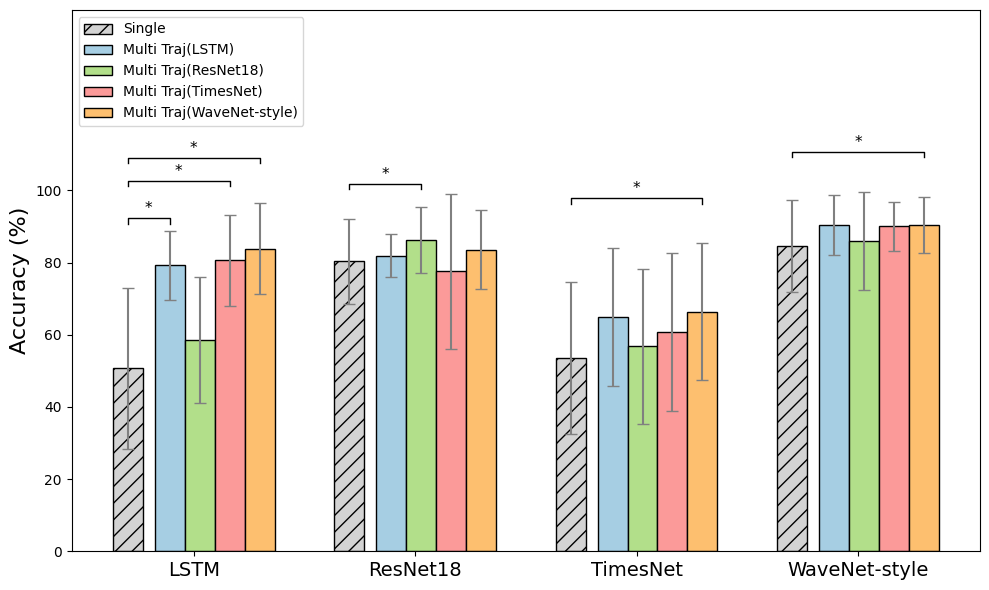

In [ ]:
# 공통 설정
modality = 'acc'     # "acc" 또는 "traj"
target   = 'severity'
traj_names = ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']
acc_names  = ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']

# 결과를 저장할 리스트 (그룹 = ACC encoder)
group_means = []        # 각 원소: 길이 5 (single + 4 multi)
group_stds  = []        # 각 원소: 길이 5
group_pvals = []        # 각 원소: 길이 4 (single vs 4 multi)
group_x     = []        # 각 원소: 길이 5, bar의 x좌표

# ─────────────────────────────
# 1) ACC encoder 별로 데이터 로드 및 통계 계산
# ─────────────────────────────
for acc_name in acc_names:
    # Single
    modal = 'single'
    csv_path = Path(
        f'/content/drive/MyDrive/MS/ETAnalysis/predictions/'
        f'{modal}/{target}/{acc_name}_{modality}_{target}_val_predictions.csv'
    )
    df_single = pd.read_csv(csv_path)
    metrics_single = compute_patient_metrics(df_single)

    # Multi
    modal = 'multi'
    metrics_multi_dict = {}
    for traj_name in traj_names:
        csv_path = Path(
            f'/content/drive/MyDrive/MS/ETAnalysis/predictions/'
            f'{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv'
        )
        df_multi = pd.read_csv(csv_path)
        metrics_multi_dict[traj_name] = compute_patient_metrics(df_multi)

    # patient_id 정렬 및 accuracy 벡터(길이 9) 추출
    pid_order = metrics_single['patient_id'].sort_values().values

    single_acc = (
        metrics_single
        .set_index('patient_id')
        .loc[pid_order, 'accuracy']
        .values
    )

    multi_acc_list = []
    for traj_name in traj_names:
        m = metrics_multi_dict[traj_name]
        acc_vec = (
            m.set_index('patient_id')
             .loc[pid_order, 'accuracy']
             .values
        )
        multi_acc_list.append(acc_vec)

    all_acc_arrays = [single_acc] + multi_acc_list

    # mean, std (0~100 %)
    means = [arr.mean() * 100.0 for arr in all_acc_arrays]
    stds  = [arr.std(ddof=1) * 100.0 for arr in all_acc_arrays]

    # paired t-test: single vs 각 multi
    p_values = []
    for acc_multi in multi_acc_list:
        t_stat, p_val = ttest_rel(single_acc, acc_multi)
        p_values.append(p_val)

    group_means.append(means)
    group_stds.append(stds)
    group_pvals.append(p_values)

# ─────────────────────────────
# 2) 플롯: 그룹(ACC encoder) x 모델(1 single+4 multi)
# ─────────────────────────────
plt.figure(figsize=(10, 6))

bar_width = 0.10          # 더 얇게
group_gap = 0.24          # 그룹 사이 간격
n_models  = 5             # single + 4 multi
n_groups  = len(acc_names)

colors = [
    '#a6cee3',  # light blue  (Multi LSTM)
    '#b2df8a',  # light green (Multi ResNet18)
    '#fb9a99',  # light red   (Multi TimesNet)
    '#fdbf6f',  # light orange(Multi WaveNet-style)
    '#cab2d6',  # light purple(예비 / 미사용)
]

legend_labels = [
    'Single',
    'Multi Traj(LSTM)',
    'Multi Traj(ResNet18)',
    'Multi Traj(TimesNet)',
    'Multi Traj(WaveNet-style)',   # ← 수정
]

# 유의성 bracket 함수
def add_sig_bracket(x1, x2, y, h=2.0, text='*'):
    plt.plot([x1, x1, x2, x2],
             [y,  y+h, y+h, y],
             color='black', linewidth=1.0)
    plt.text((x1 + x2) / 2.0,
             y + h + 0.5,
             text,
             ha='center', va='bottom', fontsize=11)

# Single bar를 왼쪽으로 조금 밀기 위한 shift
single_shift = 0.04   # 필요하면 값 조절

# x좌표 계산 및 bar 그리기
all_x = []   # 그룹별 x좌표 저장 (나중에 bracket용)

for g in range(n_groups):
    # 이 그룹(ACC encoder)의 좌측 시작 위치
    offset = g * (n_models * bar_width + group_gap)

    # 기본 x 좌표 생성
    xs = [offset + i * bar_width for i in range(n_models)]
    # Single (i=0)만 살짝 왼쪽으로 이동
    xs[0] -= single_shift

    all_x.append(xs)

    means = group_means[g]
    stds  = group_stds[g]
    pvals = group_pvals[g]

    # bar 그리기 (첫 그룹만 legend label, 나머지는 label=None)
    for i in range(n_models):
        label = legend_labels[i] if g == 0 else None

        # Single bar: 흰색 바탕 + 빗선, 나머지: 기존 color
        if i == 0:
            bar_color = 'lightgray'
            hatch = '//'   # 빗선 패턴
        else:
            bar_color = colors[i-1]  # colors[0]~[3] = 4개 multi
            hatch = None

        plt.bar(
            xs[i], means[i],
            width=bar_width,
            yerr=stds[i],
            capsize=4,
            alpha=1.0,
            color=bar_color,
            edgecolor='black',
            linewidth=1.0,
            ecolor='gray',
            hatch=hatch,
            label=label,
        )

    # single(0) vs 각 multi(1~4) 유의성 표시 (p<0.05만)
    y_single_top = means[0] + stds[0]
    for i, p in enumerate(pvals, start=1):  # i=1..4
        if p < 0.05:
            layer = i - 1
            y_multi_top = means[i] + stds[i]
            base = max(y_single_top, y_multi_top) + 2.0 + layer * 3.0
            add_sig_bracket(xs[0], xs[i], y=base, h=1.5, text='*')

plt.ylabel('Accuracy (%)', fontsize=16)
plt.yticks([0, 20, 40, 60, 80, 100])
plt.ylim(0, 150)

# x축: 각 그룹 중앙에 ACC encoder 이름 표시
group_centers = []
for xs in all_x:
    group_centers.append((xs[0] + xs[-1]) / 2.0)

# 표시용 이름에서 MyWaveNet → WaveNet-style로 변경
acc_names_disp = [name if name != 'MyWaveNet' else 'WaveNet-style'
                  for name in acc_names]

plt.xticks(group_centers, acc_names_disp, fontsize=14)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/figure/figure_5.png')
plt.show()


## Figure 3

/tmp/ipython-input-2603536612.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(patient_ids))  # patient 수만큼 색 생성


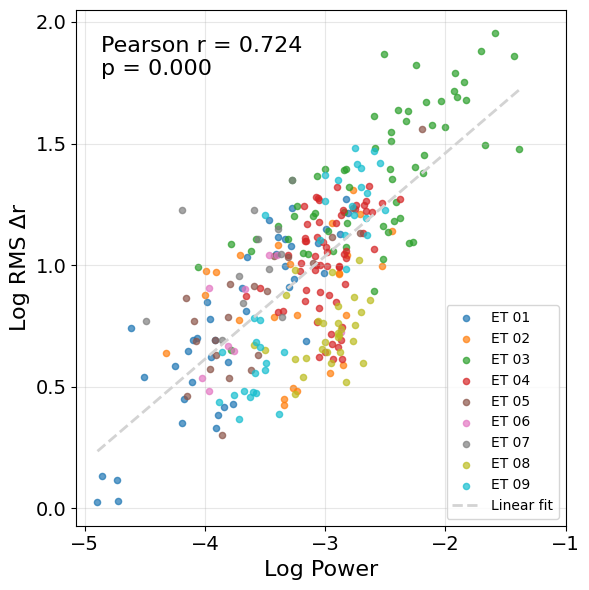

In [ ]:
from scipy.stats import pearsonr

df = pd.read_csv('/content/drive/MyDrive/MS/ETAnalysis/Data/relabel_md_k5.csv')

plt.figure(figsize=(6, 6))

patient_ids = df['patient_id'].unique()
cmap = plt.cm.get_cmap('tab10', len(patient_ids))  # patient 수만큼 색 생성

# ── 산점도 (환자별 색상) ─────────────────────
for i, pid in enumerate(sorted(patient_ids)):
    mask = df['patient_id'] == pid
    plt.scatter(
        df.loc[mask, 'log_power'],
        df.loc[mask, 'log_rms_delta_r'],
        label=f'ET 0{pid}',
        s=20,
        alpha=0.7,
        color=cmap(i),
    )

# ── NaN 제거 후 전체 데이터에 대해 상관계수 & 회귀선 계산 ──
x = df['log_power'].values
y = df['log_rms_delta_r'].values
mask_valid = np.isfinite(x) & np.isfinite(y)
x_valid = x[mask_valid]
y_valid = y[mask_valid]

# Pearson 상관계수
r, p = pearsonr(x_valid, y_valid)

# 선형 회귀 직선 (y = a x + b)
a, b = np.polyfit(x_valid, y_valid, 1)
x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
y_line = a * x_line + b

plt.plot(x_line, y_line, linewidth=2, color='lightgray', linestyle='--', label='Linear fit')

# ── 축/레이블/범례/텍스트 ─────────────────────
plt.xticks([-5, -4, -3, -2, -1], fontsize=14)
plt.yticks([0, 0.5, 1, 1.5, 2], fontsize=14)
plt.xlabel('Log Power', fontsize=16)
# plt.ylabel('Log RMS $\Delta r$', fontsize=16)
plt.ylabel('Log RMS Δr', fontsize=16)

# r, p 값 표시 (좌측 상단 예시)
plt.text(
    0.05, 0.95,
    f'Pearson r = {r:.3f}\np = {p:.3f}',
    transform=plt.gca().transAxes,
    va='top',
    ha='left',
    fontsize=16,
)

plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/figure/figure_6.png')
plt.show()

## FIgure 4

/tmp/ipython-input-3696010948.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(tasks_sorted))
/tmp/ipython-input-3696010948.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(tasks_sorted))
/tmp/ipython-input-3696010948.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(tasks_sorted))
/tmp/ipython-input-3696010948.py:30: MatplotlibDeprecationWarnin

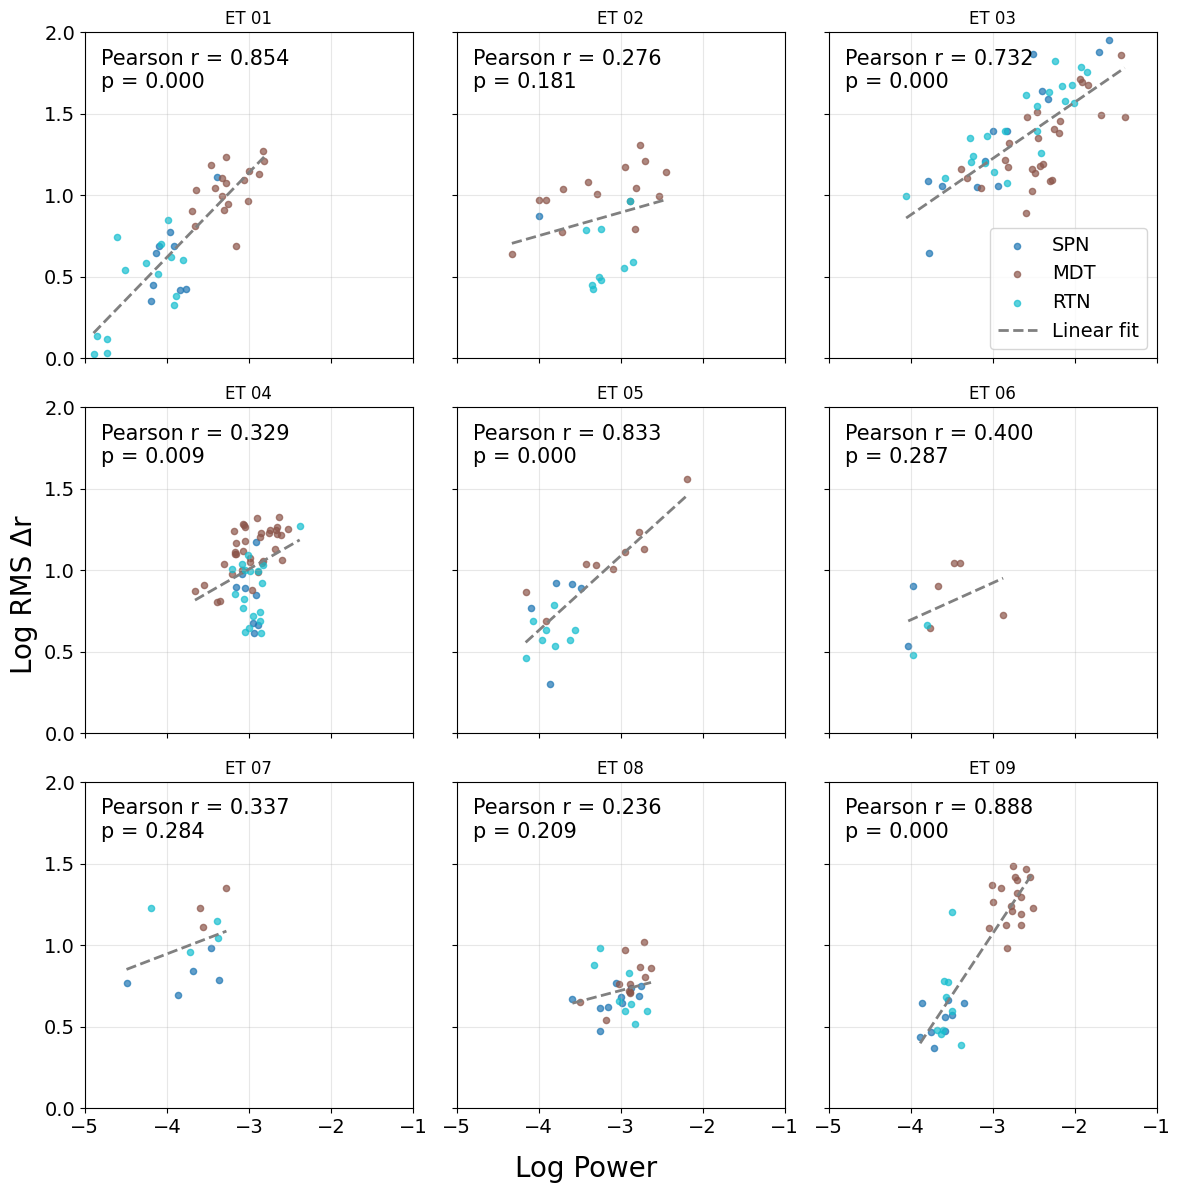

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 subplot
axes = axes.flatten()

patient_ids = sorted(df['patient_id'].unique())

task_name_map = {
    'Spiral': 'SPN',
    'Maze': 'RTN',
    'Multidirect': 'MDT',
}
order_short = ['SPN', 'MDT', 'RTN']

n_rows, n_cols = 3, 3  # subplot 그리드 크기

for idx, pid in enumerate(patient_ids):
    ax = axes[idx]

    # 현재 subplot의 (row, col) 위치
    row = idx // n_cols
    col = idx % n_cols

    mask_pid = df['patient_id'] == pid
    tasks_raw = df.loc[mask_pid, 'task'].unique()

    tasks_sorted = sorted(
        [t for t in tasks_raw if t in task_name_map],
        key=lambda t: order_short.index(task_name_map[t])
    )

    cmap = plt.cm.get_cmap('tab10', len(tasks_sorted))

    # ── task별 산점도 ─────────────────
    for i, task in enumerate(tasks_sorted):
        mask = mask_pid & (df['task'] == task)
        ax.scatter(
            df.loc[mask, 'log_power'],
            df.loc[mask, 'log_rms_delta_r'],
            label=task_name_map[task],
            s=20,
            alpha=0.7,
            color=cmap(i),
        )

    # ── Pearson r, p 및 linear fit ──
    x = df.loc[mask_pid, 'log_power'].values
    y = df.loc[mask_pid, 'log_rms_delta_r'].values
    mask_valid = np.isfinite(x) & np.isfinite(y)
    x_valid = x[mask_valid]
    y_valid = y[mask_valid]

    if len(x_valid) > 1:
        r, p = pearsonr(x_valid, y_valid)
        a, b = np.polyfit(x_valid, y_valid, 1)
        x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
        y_line = a * x_line + b

        ax.plot(
            x_line,
            y_line,
            linewidth=2,
            color='gray',
            linestyle='--',
            label='Linear fit' if (row == 0 and col == n_cols - 1) else None,
        )

        ax.text(
            0.05, 0.95,
            f'Pearson r = {r:.3f}\np = {p:.3f}',
            transform=ax.transAxes,
            va='top',
            ha='left',
            fontsize=15,
        )

    # ── 축 설정 ─────────────────
    ax.set_xlim(-5, -1)
    ax.set_ylim(0, 2)
    ax.set_xticks([-5, -4, -3, -2, -1])
    ax.set_yticks([0, 0.5, 1, 1.5, 2])
    ax.tick_params(axis='both', labelsize=14)  # ← 원하는 크기로
    ax.set_title(f'ET 0{pid}')
    ax.grid(True, alpha=0.3)

    # 위쪽 행은 xtick 라벨 숨김
    if row != n_rows - 1:
        ax.set_xlabel('')
        ax.set_xticklabels([])

    # 왼쪽 열만 ytick 라벨 보이게
    if col != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    # ── 범례: 오른쪽 맨 위 서브플롯( row=0, col=n_cols-1 )에만 표시 ──
    if (row == 0) and (col == n_cols - 1):
        handles, labels = ax.get_legend_handles_labels()

        task_handles = []
        task_labels = []
        fit_handle = None
        for h, lab in zip(handles, labels):
            if lab in order_short:
                task_handles.append(h)
                task_labels.append(lab)
            elif lab == 'Linear fit':
                fit_handle = h

        ordered_handles = []
        ordered_labels = []
        for lab in order_short:
            if lab in task_labels:
                idx_lab = task_labels.index(lab)
                ordered_handles.append(task_handles[idx_lab])
                ordered_labels.append(task_labels[idx_lab])

        if fit_handle is not None:
            ordered_handles.append(fit_handle)
            ordered_labels.append('Linear fit')

        ax.legend(ordered_handles, ordered_labels, loc='lower right', fontsize=14)
    else:
        ax.legend().set_visible(False)

# 남는 subplot 있으면 끄기
for ax in axes[len(patient_ids):]:
    ax.axis('off')

fig.supxlabel('Log Power', fontsize=20)
fig.supylabel('Log RMS Δr', fontsize=20)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/figure/figure_7_ver3.png')
plt.show()

/tmp/ipython-input-2180733571.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(tasks_sorted))  # task 수만큼 색 생성


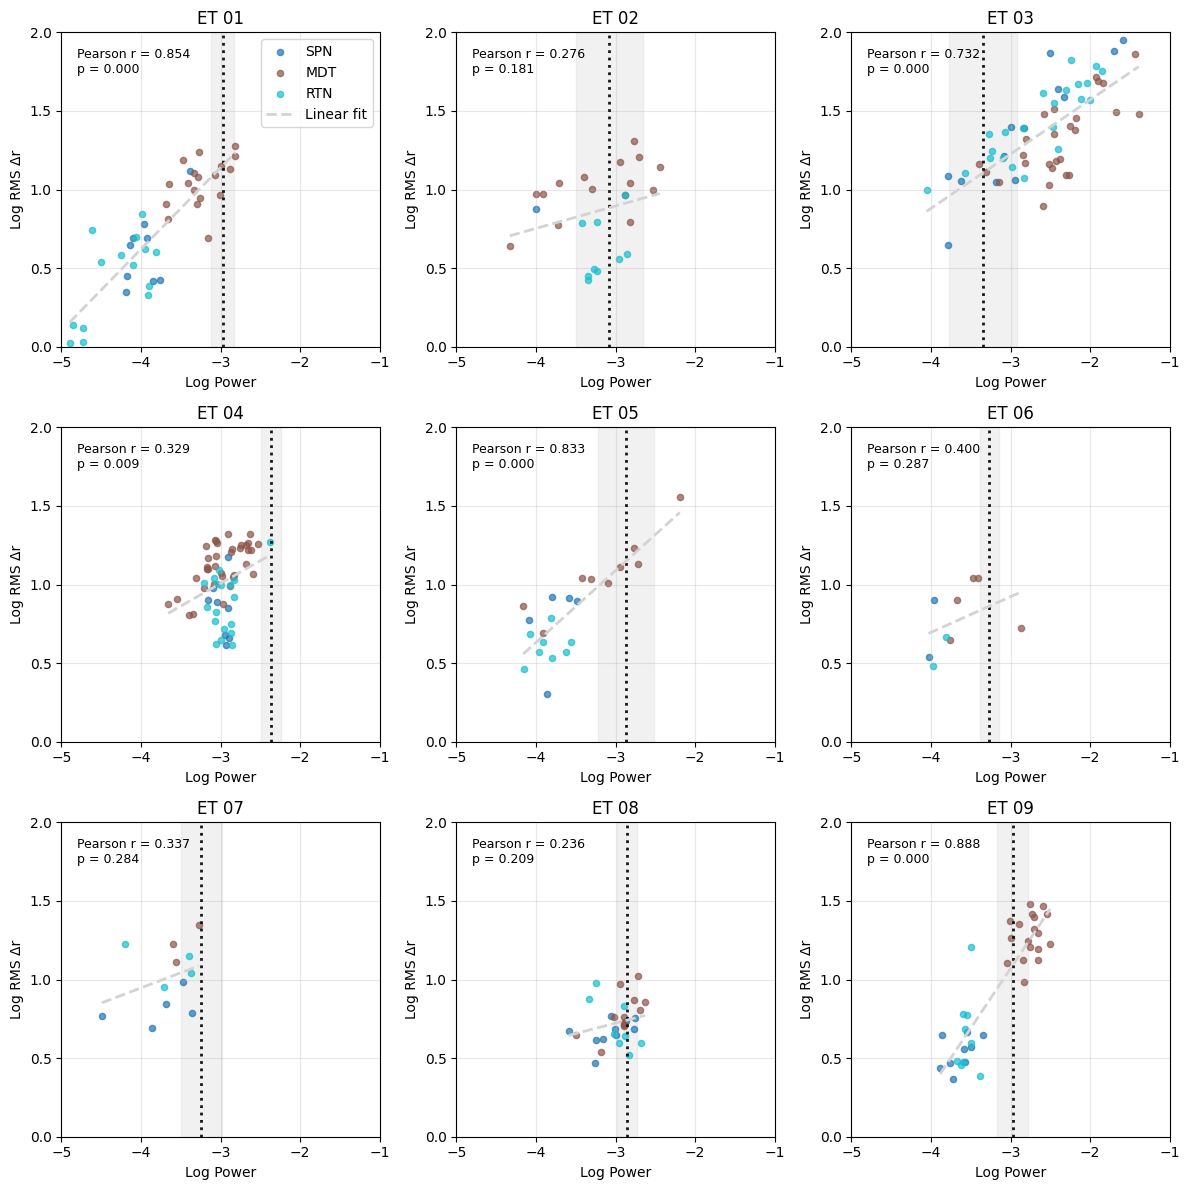

In [ ]:
calibration_df = pd.read_csv("/content/drive/MyDrive/MS/ETAnalysis/Data/calibration_power_summary.csv")
calibration_df['log_power'] = np.log10(calibration_df['normalized_power'])

fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 subplot
axes = axes.flatten()

patient_ids = sorted(df['patient_id'].unique())

# task 이름 매핑 및 순서 정의
task_name_map = {
    'Spiral': 'SPN',
    'Maze': 'RTN',
    'Multidirect': 'MDT',
}
order_short = ['SPN', 'MDT', 'RTN']  # 범례 표기 순서

# ── calibration_df 에서 patient별 log_power 값 미리 모으기 ─────────────
# calibration_df: 'patient_id', 'log_power' 컬럼이 있다고 가정
calib_by_pid = {}
for pid in patient_ids:
    mask_calib = calibration_df['patient_id'] == pid
    calib_by_pid[pid] = calibration_df.loc[mask_calib, 'log_power'].values

for idx, pid in enumerate(patient_ids):
    ax = axes[idx]

    # 해당 patient mask
    mask_pid = df['patient_id'] == pid

    # 해당 patient 내 task 목록 (원래 이름 기준)
    tasks_raw = df.loc[mask_pid, 'task'].unique()

    # 이 patient에서 실제로 등장한 task들에 대해, 짧은 이름 기준 정렬
    tasks_sorted = sorted(
        [t for t in tasks_raw if t in task_name_map],
        key=lambda t: order_short.index(task_name_map[t])
    )

    cmap = plt.cm.get_cmap('tab10', len(tasks_sorted))  # task 수만큼 색 생성

    # ── task별 산점도 ─────────────────
    for i, task in enumerate(tasks_sorted):
        mask = mask_pid & (df['task'] == task)
        ax.scatter(
            df.loc[mask, 'log_power'],
            df.loc[mask, 'log_rms_delta_r'],
            label=task_name_map[task],  # SPN / RTN / MDT 로 표기
            s=20,
            alpha=0.7,
            color=cmap(i),
        )

    # ── calibration log_power: 평균 수직선 + 표준편차 음영 ─────────────
    calib_vals = calib_by_pid.get(pid, np.array([]))
    calib_vals = calib_vals[np.isfinite(calib_vals)]  # NaN/inf 제거

    if calib_vals.size > 0:
        mean_calib = calib_vals.mean()
        std_calib = calib_vals.std(ddof=0)

        # 표준편차 구간 음영 (밝은 회색)
        if std_calib > 0:
            ax.axvspan(
                mean_calib - std_calib,
                mean_calib + std_calib,
                color='lightgray',  # 밝은 회색
                alpha=0.3,
                zorder=0,          # 점/선보다 뒤에 오도록
            )

        # 평균 수직선
        ax.axvline(
            x=mean_calib,
            linestyle=':',
            linewidth=2,
            color='black',
            alpha=0.9,
        )

    # ── Pearson r, p 및 linear fit (해당 patient 데이터만) ──
    x = df.loc[mask_pid, 'log_power'].values
    y = df.loc[mask_pid, 'log_rms_delta_r'].values
    mask_valid = np.isfinite(x) & np.isfinite(y)
    x_valid = x[mask_valid]
    y_valid = y[mask_valid]

    if len(x_valid) > 1:
        # Pearson 상관계수
        r, p = pearsonr(x_valid, y_valid)

        # 선형 회귀 직선 (y = a x + b)
        a, b = np.polyfit(x_valid, y_valid, 1)
        x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
        y_line = a * x_line + b

        ax.plot(
            x_line,
            y_line,
            linewidth=2,
            color='lightgray',
            linestyle='--',
            label='Linear fit' if idx == 0 else None,  # legend는 첫 플롯에만
        )

        # r, p 값 텍스트
        ax.text(
            0.05, 0.95,
            f'Pearson r = {r:.3f}\np = {p:.3f}',
            transform=ax.transAxes,
            va='top',
            ha='left',
            fontsize=9,
        )

    # ── 축 설정 ─────────────────
    ax.set_xlim(-5, -1)
    ax.set_ylim(0, 2)
    ax.set_xticks([-5, -4, -3, -2, -1])
    ax.set_yticks([0, 0.5, 1, 1.5, 2])

    ax.set_xlabel('Log Power')
    ax.set_ylabel('Log RMS Δr')
    ax.set_title(f'ET 0{pid}')
    ax.grid(True, alpha=0.3)

    # 첫 번째 서브플롯에만 legend 표시 (SPN, RTN, MDT 순서 유지)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()

        # Linear fit과 task들을 분리
        task_handles = []
        task_labels = []
        fit_handle = None
        for h, lab in zip(handles, labels):
            if lab in order_short:
                task_handles.append(h)
                task_labels.append(lab)
            elif lab == 'Linear fit':
                fit_handle = h

        # task legend를 SPN, RTN, MDT 순서로 재정렬
        ordered_handles = []
        ordered_labels = []
        for lab in order_short:
            if lab in task_labels:
                idx_lab = task_labels.index(lab)
                ordered_handles.append(task_handles[idx_lab])
                ordered_labels.append(task_labels[idx_lab])

        # Linear fit은 마지막에 추가 (있을 경우)
        if fit_handle is not None:
            ordered_handles.append(fit_handle)
            ordered_labels.append('Linear fit')

        ax.legend(ordered_handles, ordered_labels, loc='upper right')
    else:
        ax.legend().set_visible(False)

# 남는 subplot 있으면 끄기 (환자 수가 9 미만인 경우)
for ax in axes[len(patient_ids):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Supplementary Figure 1

/tmp/ipython-input-1468791341.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in df_plot.sort_values('tetras_score').groupby('tetras_score')
/tmp/ipython-input-1468791341.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


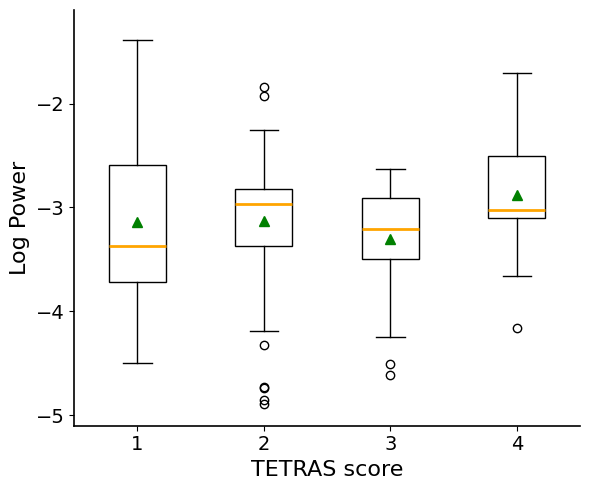

In [3]:
df = pd.read_csv('/content/drive/MyDrive/MS/ETAnalysis/Data/relabel_md_k5.csv')

df_plot = df[['tetras_score', 'log_power']].dropna().copy()

# tetras_score 정렬/범주화
if df_plot['tetras_score'].dtype.kind in {'i','u','f'}:
    order = sorted(df_plot['tetras_score'].unique())
else:
    order = sorted(pd.to_numeric(df_plot['tetras_score'], errors='coerce').dropna().unique())
df_plot['tetras_score'] = pd.Categorical(df_plot['tetras_score'], categories=order, ordered=True)

# 그룹 데이터
groups = [
    g['log_power'].values
    for _, g in df_plot.sort_values('tetras_score').groupby('tetras_score')
]
labels = [str(k) for k in df_plot['tetras_score'].cat.categories if pd.notna(k)]

plt.figure(figsize=(6, 5))
bp = plt.boxplot(
    groups,
    labels=labels,
    patch_artist=True,
    showmeans=True,
    whis=1.5,
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='orange', linewidth=2.0),
    meanprops=dict(marker='^', markersize=7,
                   markerfacecolor='green', markeredgecolor='green')
)

# 스파인 제어: 상·우 제거, 하·좌 유지
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

plt.ylim(-5.1, -1.1)
plt.yticks([-5, -4, -3, -2])
plt.xlabel("TETRAS score", fontsize=16)
plt.ylabel("Log Power", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/digital medicine/figure/S_figure1.png')
plt.show()

## Supplementary Figure 2

Patient ID | Gen N  | Cal N  | P-Value    | Result
------------------------------------------------------------
1          | 41     | 3      | 0.0125    | ** Diff **
2          | 25     | 2      | 0.7521    | Same
3          | 61     | 10     | 0.0006    | ** Diff **
4          | 62     | 5      | 0.0000    | ** Diff **
5          | 22     | 8      | 0.0036    | ** Diff **
6          | 9      | 2      | 0.1455    | Same
7          | 12     | 3      | 0.1011    | Same
8          | 30     | 8      | 0.2500    | Same
9          | 36     | 4      | 0.5568    | Same


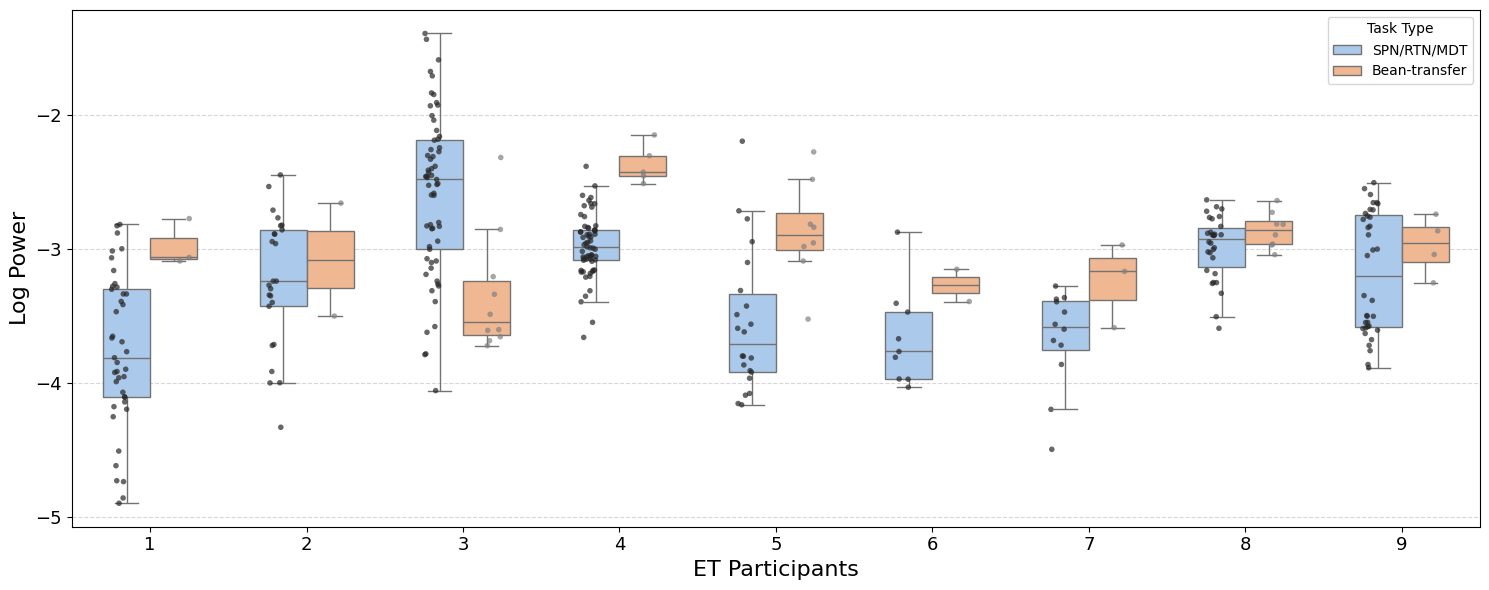

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MS/ETAnalysis/Data/relabel_md_k5.csv')
calibration_df = pd.read_csv("/content/drive/MyDrive/MS/ETAnalysis/Data/calibration_power_summary.csv")
calibration_df['log_power'] = np.log10(calibration_df['normalized_power'])

# --- 데이터 전처리 및 병합 ---
# 1. 각 데이터프레임에 출처(Source)를 구분하는 컬럼 추가
df = df.copy()
df['Task_Type'] = 'SPN/RTN/MDT'

calibration_df = calibration_df.copy()
calibration_df['Task_Type'] = 'Bean-transfer'

# 2. 분석을 위해 두 데이터프레임을 하나로 병합 (row-wise concatenation)
# (환자 ID 컬럼명이 'patient_id'라고 가정합니다. 만약 'patient_df'라면 수정해주세요)
combined_df = pd.concat([df, calibration_df], axis=0, ignore_index=True)

# --- 1. 통계적 분석 (환자별 Mann-Whitney U Test) ---
stat_results = []
unique_patients = combined_df['patient_id'].unique()
unique_patients.sort()

print(f"{'Patient ID':<10} | {'Gen N':<6} | {'Cal N':<6} | {'P-Value':<10} | {'Result'}")
print("-" * 60)

for pid in unique_patients:
    # 해당 환자의 데이터 추출
    data_gen = df[df['patient_id'] == pid]['log_power'].dropna()
    data_cal = calibration_df[calibration_df['patient_id'] == pid]['log_power'].dropna()

    n_gen = len(data_gen)
    n_cal = len(data_cal)

    # 두 그룹 모두 데이터가 최소 2개 이상일 때만 검정 수행 가능
    if n_gen > 1 and n_cal > 1:
        # Mann-Whitney U Test (alternative='two-sided')
        stat, p_val = stats.mannwhitneyu(data_gen, data_cal, alternative='two-sided')
        result_str = "** Diff **" if p_val < 0.05 else "Same"
    else:
        p_val = np.nan
        result_str = "Not enough data"

    stat_results.append({
        'patient_id': pid,
        'n_general': n_gen,
        'n_calibration': n_cal,
        'p_value': p_val
    })

    print(f"{pid:<10} | {n_gen:<6} | {n_cal:<6} | {p_val:.4f}    | {result_str}")

# 결과를 데이터프레임으로 저장
stat_df = pd.DataFrame(stat_results)

# --- 2. 시각화 (Boxplot + Stripplot) ---
plt.figure(figsize=(15, 6))

# (1) Boxplot: 전반적인 분포 (중앙값, 사분위수) 표시
sns.boxplot(
    data=combined_df,
    x='patient_id',
    y='log_power',
    hue='Task_Type',
    palette="pastel",  # 부드러운 색상
    showfliers=False,  # strip plot을 겹칠 것이므로 boxplot의 outlier 점은 숨김
    width=0.6
)

# (2) Stripplot: 실제 데이터 포인트 표시 (n수가 적을 때 매우 중요)
sns.stripplot(
    data=combined_df,
    x='patient_id',
    y='log_power',
    hue='Task_Type',
    palette="dark:gray", # 점은 어둡게 표시하여 가시성 확보
    dodge=True,          # Boxplot과 동일하게 hue 별로 위치 분리
    jitter=True,         # 점들이 겹치지 않게 약간 흩뿌림
    alpha=0.7,           # 투명도
    size=4
)

# 범례 정리 (Strip plot 범례는 제거하고 Boxplot 범례만 남김)
handles, labels = plt.gca().get_legend_handles_labels()
plt.yticks([-5, -4, -3, -2])
plt.tick_params(axis='both', labelsize=13)
plt.legend(handles[:2], labels[:2], title='Task Type', loc='upper right')

# plt.title('Comparison of Log Power Distribution: General Tasks vs. Calibration', fontsize=15)
plt.ylabel('Log Power', fontsize=16)
plt.xlabel('ET Participants', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Supplementary Figure 3

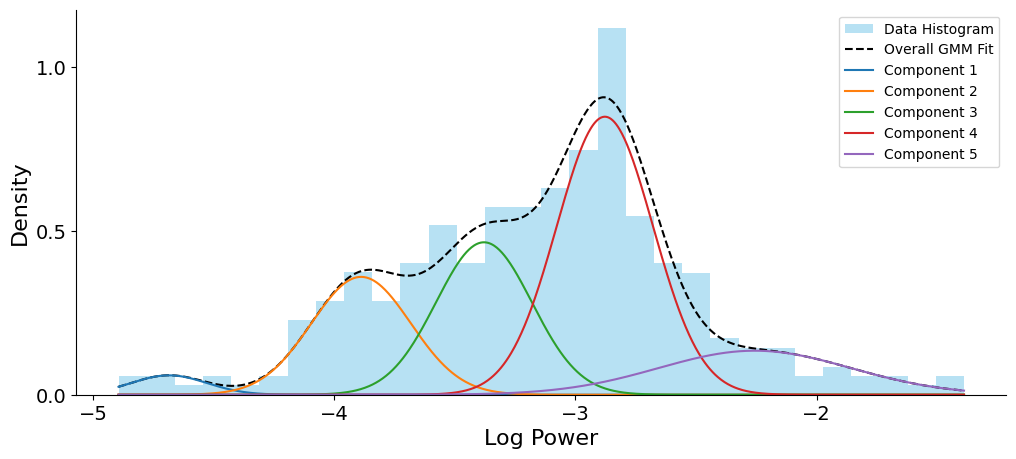

In [5]:
def plot_gmm_single(
    df,
    column,
    *,
    k=3,
    bins=30,
    n_init=100,
    random_state=42,
    grid_points=1000,
    covariance_type='full',
    ax=None,
    reset_cycle=True
):
    """
    단일 수치 컬럼(1D)에 대해 지정한 k 값으로 GMM 적합/시각화.
    (컴포넌트 레이블이 왼쪽부터 1, 2, 3...이 되도록 정렬)
    """
    # --- 데이터 준비 ---
    x = df[column].to_numpy(dtype=float)
    x = x[np.isfinite(x)]
    if x.size < max(3, k):
        raise ValueError(f"유효 표본 {x.size}개: 최소 max(3, k)={max(3,k)} 이상 필요합니다.")
    X = x.reshape(-1, 1)

    x_min, x_max = float(np.min(x)), float(np.max(x))
    if x_min == x_max:
        eps = max(1e-6, 0.01 * max(1.0, abs(x_min)))
        x_min, x_max = x_min - eps, x_max + eps
    x_range = np.linspace(x_min, x_max, grid_points).reshape(-1, 1)

    def _comp_std(gmm, i):
        ct = gmm.covariance_type
        if ct == 'full':
            var = gmm.covariances_[i][0, 0]
        elif ct == 'diag':
            var = gmm.covariances_[i][0]
        elif ct == 'spherical':
            var = gmm.covariances_[i]
        elif ct == 'tied':
            var = gmm.covariances_[0, 0]
        else:
            raise ValueError(f"지원되지 않는 covariance_type: {ct}")
        return np.sqrt(var)

    # --- GMM 적합 ---
    gmm = GaussianMixture(
        n_components=k,
        n_init=n_init,
        random_state=random_state,
        covariance_type=covariance_type
    ).fit(X)

    # --- 플로팅 ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
        created_fig = True

    # (1) 히스토그램
    ax.hist(x, bins=bins, density=True, color='skyblue', alpha=0.6, label='Data Histogram')

    # (2) 전체 혼합분포 (검정 점선)
    log_prob = gmm.score_samples(x_range)
    pdf = np.exp(log_prob)
    ax.plot(x_range, pdf, color='black', linestyle='--', label='Overall GMM Fit')

    # (3) 컴포넌트: 색상 순환 초기화로 일관성 유지
    if reset_cycle:
        default_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)
        if default_colors:
            ax.set_prop_cycle(cycler(color=default_colors))

    # --- 정렬된 컴포넌트 플롯 ---
    sorted_indices = np.argsort(gmm.means_.ravel())
    for label_idx, original_idx in enumerate(sorted_indices):
        mu = gmm.means_[original_idx, 0]
        sd = _comp_std(gmm, original_idx)
        w = gmm.weights_[original_idx]
        comp_pdf = w * norm.pdf(x_range.ravel(), loc=mu, scale=sd)
        ax.plot(x_range, comp_pdf, label=f'Component {label_idx + 1}')

    # 라벨/범례
    ax.set_xlabel('Log Power', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    ax.legend()

    # ── 요청한 스타일 적용: 상/우 스파인 숨김 + 틱 지정 ──
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xticks([-5, -4, -3, -2])
    ax.tick_params(axis='both', labelsize=14)
    # fig.savefig('/content/drive/MyDrive/MS/ETAnalysis/figure/figure_2_c.png')
    plt.show()

    return gmm, ax


gmm, ax = plot_gmm_single(df, 'log_power', k=5)

## Supplementary Figure 4

/tmp/ipython-input-272000664.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in df_plot.sort_values('target_k5').groupby('target_k5')
/tmp/ipython-input-272000664.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


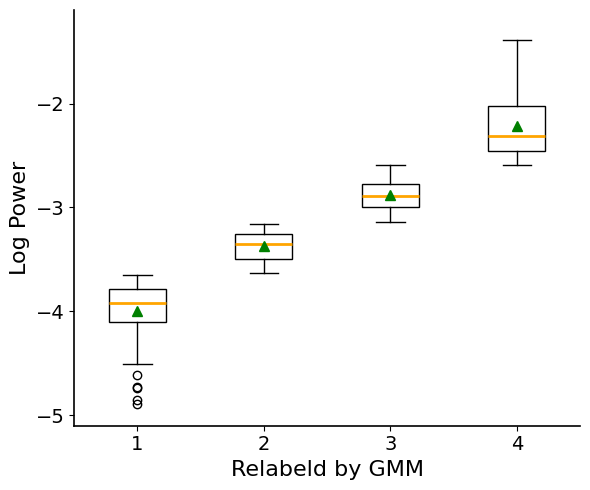

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MS/ETAnalysis/Data/relabel_md_k5.csv')

df_plot = df[['target_k5', 'log_power']].dropna().copy()

# target_k5 정렬/범주화 (0,1,2,3)
if df_plot['target_k5'].dtype.kind in {'i','u','f'}:
    order = sorted(df_plot['target_k5'].unique())
else:
    order = sorted(pd.to_numeric(df_plot['target_k5'], errors='coerce').dropna().unique())
df_plot['target_k5'] = pd.Categorical(df_plot['target_k5'], categories=order, ordered=True)

# 그룹 데이터 (0~3 값별)
groups = [
    g['log_power'].values
    for _, g in df_plot.sort_values('target_k5').groupby('target_k5')
]

# 표시용 라벨만 +1 (0→1, 1→2, 2→3, 3→4)
labels = [str(int(k) + 1) for k in df_plot['target_k5'].cat.categories if pd.notna(k)]

plt.figure(figsize=(6, 5))
bp = plt.boxplot(
    groups,
    labels=labels,
    patch_artist=True,
    showmeans=True,
    whis=1.5,
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='orange', linewidth=2.0),
    meanprops=dict(marker='^', markersize=7,
                   markerfacecolor='green', markeredgecolor='green')
)

# 스파인 제어: 상·우 제거, 하·좌 유지
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

plt.ylim(-5.1, -1.1)
plt.yticks([-5, -4, -3, -2])
plt.xlabel("Relabeld by GMM", fontsize=16)
plt.ylabel("Log Power", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/digital medicine/figure/S_figure2.png')
plt.show()

## Supplementary Figure 5

In [6]:
calibration_df = pd.read_csv("/content/drive/MyDrive/MS/ETAnalysis/Data/calibration_power_summary.csv")
calibration_df['log_power'] = np.log10(calibration_df['normalized_power'])

# 1. 예측할 데이터 준비
X_calib = calibration_df['log_power'].values.reshape(-1, 1)

# 2. GMM 예측 (내부 인덱스 반환)
raw_labels = gmm.predict(X_calib)

# 3. 평균(mean) 기준으로 정렬 순서 파악
sorted_indices = np.argsort(gmm.means_.ravel())

# 4. 내부 인덱스 -> 정렬된 라벨(0, 1, 2, 3...)로 매핑 (여기서는 +1을 하지 않음)
index_map = {original_idx: rank for rank, original_idx in enumerate(sorted_indices)}
calibration_df['gmm_pred'] = [index_map[label] for label in raw_labels]

# 5. [요청사항] 0인 값을 1로 수정
# 결과적으로 0번과 1번 그룹이 모두 1이 되며, 나머지(2, 3, 4...)는 유지됨
calibration_df.loc[calibration_df['gmm_pred'] == 0, 'gmm_pred'] = 1

result = calibration_df.loc[calibration_df['file'].str.endswith('calibration_1.txt')]

--- 분석 대상: tetras_score vs gmm_pred (n=25) ---

1. 순위 상관분석
   - Spearman Correlation: 0.5914 (p=0.0018)
   - Kendall's Tau       : 0.5356 (p=0.0029)

2. 일치도 분석 (Quadratic Weighted Kappa)
   - QWK Score: 0.3666
     (0.8+ : 아주 좋음, 0.6~0.8 : 좋음, 0.4~0.6 : 보통)


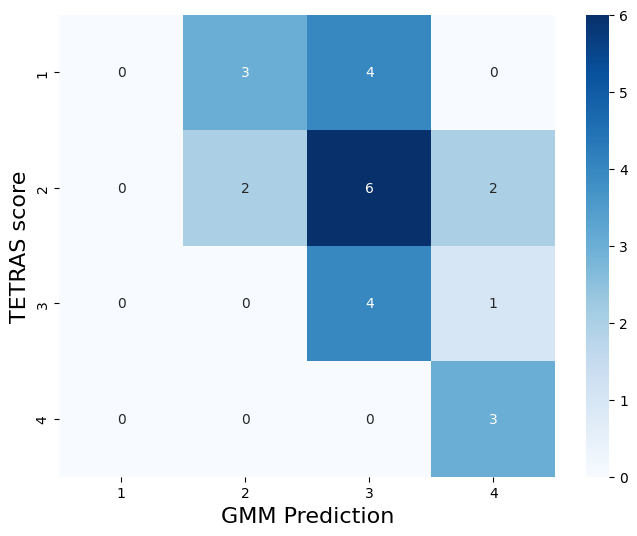

In [ ]:
from scipy import stats
from sklearn.metrics import cohen_kappa_score, confusion_matrix

def analyze_ordinal_agreement(df, col_true, col_pred):
    """
    순서형 변수 간의 통계적 비교 및 시각화
    col_true: 정답/기준 컬럼 (예: tetras_score)
    col_pred: 예측/비교 컬럼 (예: gmm_pred)
    """
    # 데이터 준비 (결측치 제거)
    clean_df = df[[col_true, col_pred]].dropna()
    y_true = clean_df[col_true]
    y_pred = clean_df[col_pred]

    print(f"--- 분석 대상: {col_true} vs {col_pred} (n={len(clean_df)}) ---")

    # 1. 순위 상관계수 (Rank Correlation)
    # Spearman: 일반적인 순위 상관관계
    rho, p_spearman = stats.spearmanr(y_true, y_pred)
    # Kendall's Tau: 동점(ties)이 많을 때 더 견고함 (점수가 0~4로 제한적이므로 적합)
    tau, p_kendall = stats.kendalltau(y_true, y_pred)

    print(f"\n1. 순위 상관분석")
    print(f"   - Spearman Correlation: {rho:.4f} (p={p_spearman:.4f})")
    print(f"   - Kendall's Tau       : {tau:.4f} (p={p_kendall:.4f})")

    # 2. 일치도 분석 (Weighted Kappa)
    # weights='quadratic': 틀린 정도(거리)에 가중치 부여 (1점 차이 < 3점 차이)
    # 임상 척도 비교에서 표준으로 많이 사용됨 (QWK)
    qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

    print(f"\n2. 일치도 분석 (Quadratic Weighted Kappa)")
    print(f"   - QWK Score: {qwk:.4f}")
    print("     (0.8+ : 아주 좋음, 0.6~0.8 : 좋음, 0.4~0.6 : 보통)")

    # 3. Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))

    # 교차표 생성
    labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel(f'GMM Prediction', fontsize=16)
    plt.ylabel(f'TETRAS score', fontsize=16)
    plt.show()

# 사용 예시 (result 또는 calibration_df 사용)
# 데이터프레임 변수명은 상황에 맞게 변경하세요.
analyze_ordinal_agreement(result, 'tetras_score', 'gmm_pred')

## Supplementary Figure 6

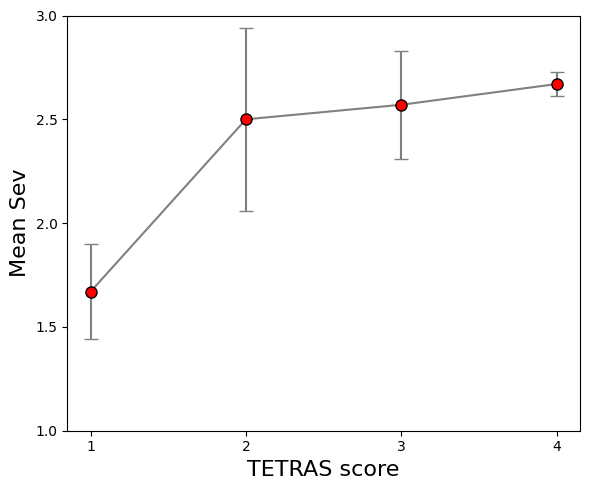

In [10]:
table = pd.read_csv('/content/drive/MyDrive/MS/ETAnalysis/figure/Table4.csv')

group = table.groupby("TETRAS")["Mean Sev"]

# 2) median ± MAD
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

medians = group.median()
mads = group.apply(mad)
x_med = medians.index.values

plt.figure(figsize=(6, 5))
plt.errorbar(
    x_med,
    medians.values,
    yerr=mads.values,
    fmt='o-',          # 점 + 선
    capsize=5,
    ecolor='gray',     # error bar 색: 회색
    color='gray',     # 점을 잇는 선 색: 검정
    markerfacecolor='red',  # 점 내부 색: 빨간색
    markeredgecolor='black',  # 점 외곽선 색: 빨간색
    markersize=8       # 점 크기 키우기
)
mask_valid = table[['Mean Sev', 'TETRAS']].notna().all(axis=1)
mean_sev = table.loc[mask_valid, 'Mean Sev'].astype(float)
tetras   = table.loc[mask_valid, 'TETRAS'].astype(int)


plt.ylim(1, 3)
plt.yticks([1, 1.5, 2, 2.5, 3])
plt.xticks([1, 2, 3, 4])
plt.xlabel("TETRAS score", fontsize=16)
plt.ylabel("Mean Sev", fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/digital medicine/figure/S_figure4.png')
plt.show()